# Names Analysis & Modeling

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import os

In [ ]:
sys.path.append(os.path.abspath(".."))

from ners.core.utils.data_loader import DataLoader
from ners.core.utils.region_mapper import RegionMapper
from ners.core.config.pipeline_config import PipelineConfig

from ners.research.statistics.utils import LETTERS
from ners.research.statistics.utils import build_category_distribution
from ners.research.statistics.utils import build_words_token
from ners.research.statistics.utils import build_transition_probabilities
from ners.research.statistics.utils import build_transition_comparisons
from ners.research.statistics.utils import build_ngrams_count
from ners.research.statistics.plots import plot_transition_matrix
from ners.research.statistics.plots import plot_letter_frequencies

In [3]:
config = PipelineConfig(
    paths={
        "root_dir": "../data",
        "data_dir": "../data/dataset",
        "models_dir": "../models",
        "outputs_dir": "../data/processed",
        "logs_dir": "../logs",
        "configs_dir": "../configs",
        "checkpoints_dir": "../checkpoints",
    }
)

loader = DataLoader(config)

In [4]:
df = loader.load_csv_complete(config.paths.data_dir / "names_featured.csv")
df["province"] = RegionMapper.clean_province(df["province"])
df.columns

Index(['name', 'sex', 'region', 'words', 'length', 'probable_native',
       'probable_surname', 'identified_name', 'identified_surname',
       'ner_entities', 'ner_tagged', 'annotated', 'identified_category',
       'province'],
      dtype='object')

## Name category distribution

In [5]:
df_name_categories = build_category_distribution(df)
df_name_categories.head(12)

# save data
df_name_categories.to_csv("../assets/identified_category_distribution.csv", index=False)

### Simple vs Compose (all provinces)

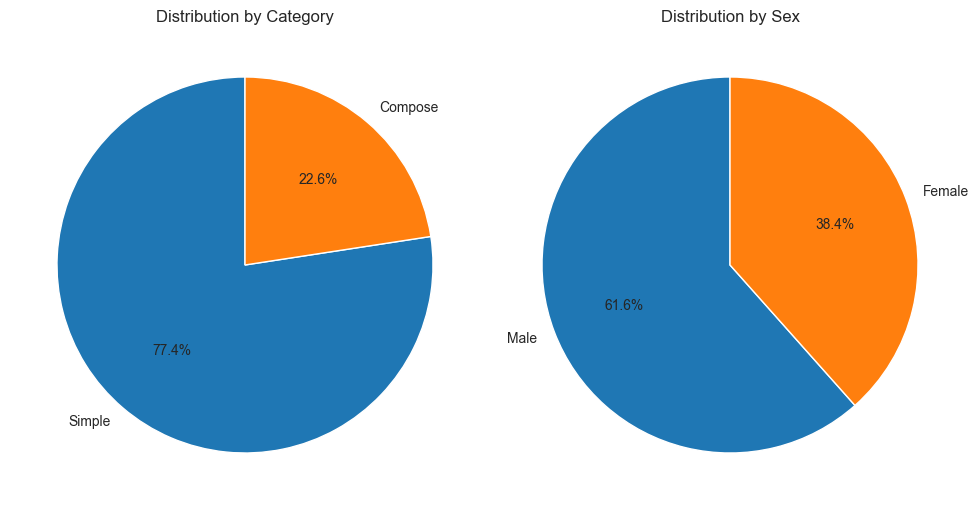

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# Pie 1: Simple vs Compose
labels = ["Simple", "Compose"]
values = [
    len(df.query("identified_category == 'simple'")),
    len(df.query("identified_category == 'compose'")),
]
axes[0].pie(values, labels=labels, autopct="%1.1f%%", startangle=90)
axes[0].set_title("Distribution by Category")

# Pie 2: Male vs Female
labels = ["Male", "Female"]
values = [len(df.query("sex == 'm'")), len(df.query("sex == 'f'"))]
axes[1].pie(values, labels=labels, autopct="%1.1f%%", startangle=90)
axes[1].set_title("Distribution by Sex")

for ax in axes.flat:
    ax.set_aspect("equal")

plt.tight_layout()

# Save figures
plt.savefig("../assets/distribution_grid.png")
plt.savefig("../assets/distribution_grid.svg")

plt.show()

### Simple vs Compose by Province

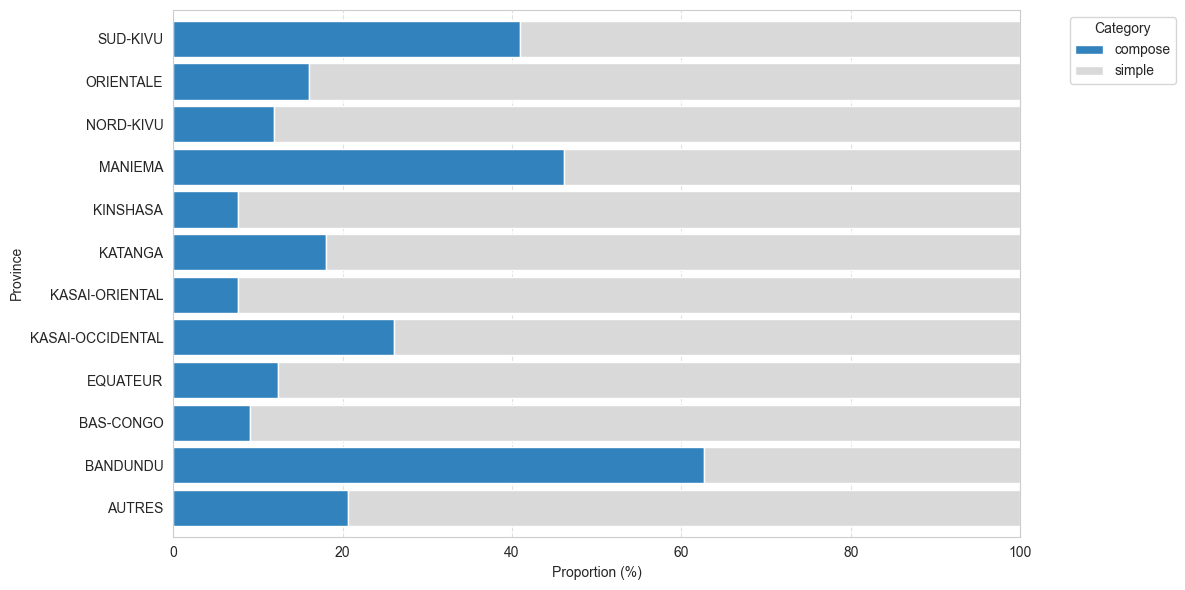

In [7]:
df_name_categories_pct = (
    df_name_categories.div(df_name_categories.sum(axis=1), axis=0) * 100
)
ax = df_name_categories_pct.plot.barh(
    stacked=True, figsize=(12, 6), colormap="tab20c", width=0.85
)

ax.set_xlabel("Proportion (%)")
ax.set_ylabel("Province")
ax.set_xlim(0, 100)
ax.grid(axis="x", linestyle="--", alpha=0.6)

plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# save figures
plt.savefig("../assets/identified_category_distribution_by_province.png")
plt.savefig("../assets/identified_category_distribution_by_province.svg")

plt.show()

## Native Names vs Surnames

In [8]:
df_base = df.query("identified_category == 'simple'")

In [9]:
df_names = build_words_token(df_base, "identified_name", "name")
df_names = df_names[["name", "province", "sex"]].reset_index(drop=True)
df_names.describe().T

,count,unique,top,freq
name,10015595,644336,ilunga,82342
province,10015595,12,KINSHASA,2106077
sex,10015595,2,m,6033856


In [10]:
df_surnames = build_words_token(df_base, "identified_surname", "name")
df_surnames = df_surnames[["name", "province", "sex"]].reset_index(drop=True)
df_surnames.describe().T

,count,unique,top,freq
name,5007877,253743,jean,89564
province,5007877,12,KINSHASA,1053047
sex,5007877,2,m,3017009


In [11]:
df_names_m = df_names.query("sex == 'm'")
df_names_f = df_names.query("sex == 'f'")

df_surnames_m = df_surnames.query("sex == 'm'")
df_surnames_f = df_surnames.query("sex == 'f'")

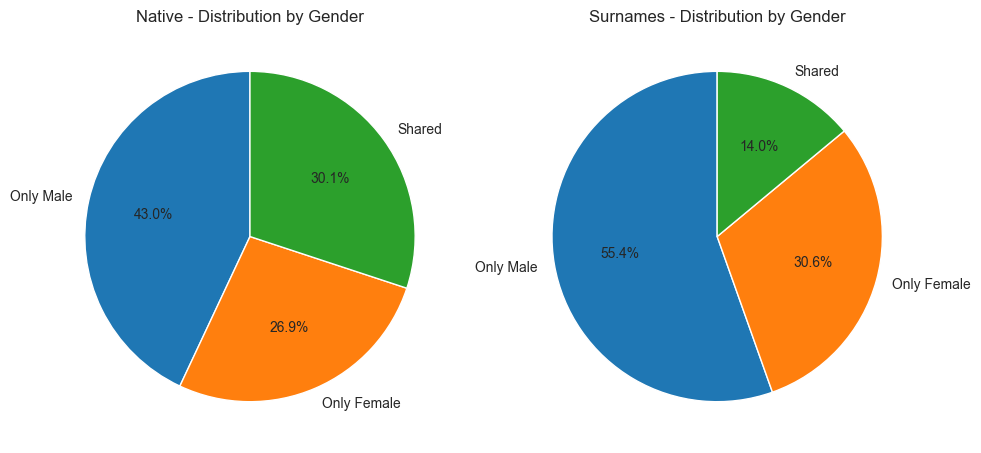

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

labels = ["Only Male", "Only Female", "Shared"]

# Native names
names_m = set(df_names_m["name"].str.lower())
names_f = set(df_names_f["name"].str.lower())

values = [len(names_m - names_f), len(names_f - names_m), len(names_m & names_f)]
axes[0].pie(values, labels=labels, autopct="%1.1f%%", startangle=90)
axes[0].set_title("Native - Distribution by Gender")

# Surnames
surnames_m = set(df_surnames_m["name"].str.lower())
surnames_f = set(df_surnames_f["name"].str.lower())

values = [
    len(surnames_m - surnames_f),
    len(surnames_f - surnames_m),
    len(surnames_m & surnames_f),
]
axes[1].pie(values, labels=labels, autopct="%1.1f%%", startangle=90)
axes[1].set_title("Surnames - Distribution by Gender")

# Formatting
for ax in axes.flat:
    ax.set_aspect("equal")

plt.tight_layout()

# Save figures
plt.savefig("../assets/name_by_gender_distribution_grid.png")
plt.savefig("../assets/name_by_gender_distribution_grid.svg")

plt.show()

In [13]:
names_transitions = build_transition_probabilities(df_names["name"])
names_transitions_males = build_transition_probabilities(df_names_m["name"])
names_transitions_females = build_transition_probabilities(df_names_f["name"])

names_transitions["df_probs"].to_csv(
    "../assets/names_transition_probs.csv", index=False
)

In [14]:
surnames_transitions = build_transition_probabilities(df_surnames["name"])
surnames_transitions_males = build_transition_probabilities(df_surnames_m["name"])
surnames_transitions_females = build_transition_probabilities(df_surnames_f["name"])

surnames_transitions["df_probs"].to_csv(
    "../assets/surnames_transition_probs.csv", index=False
)

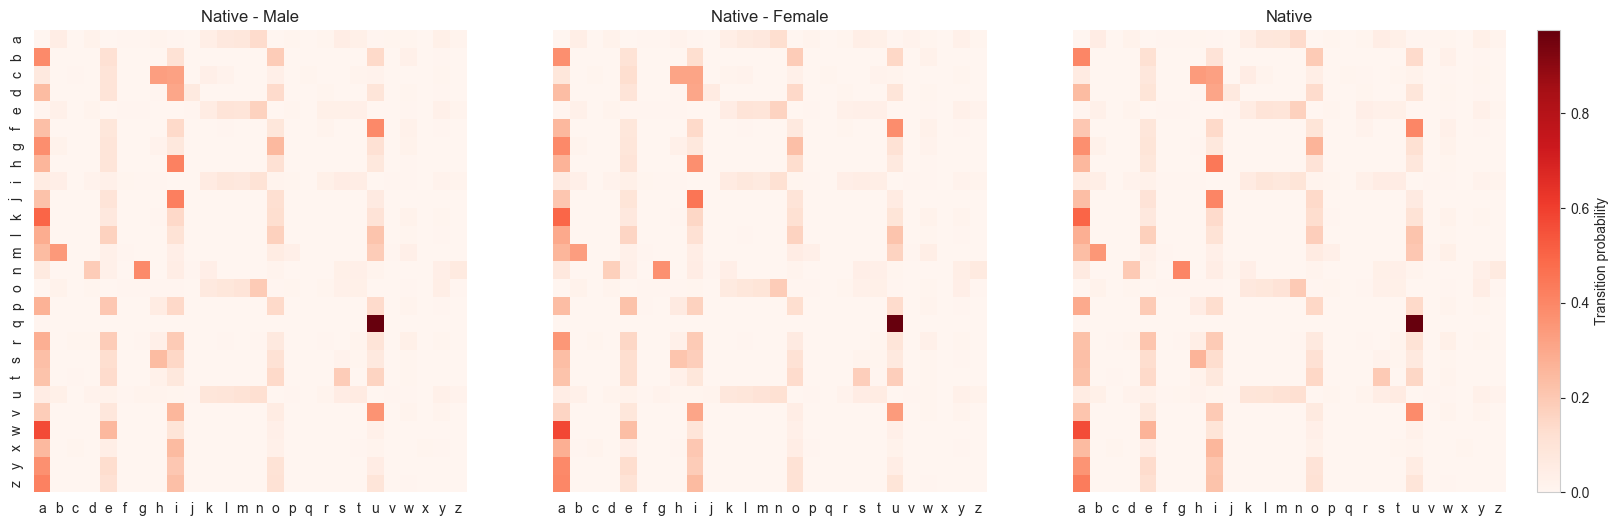

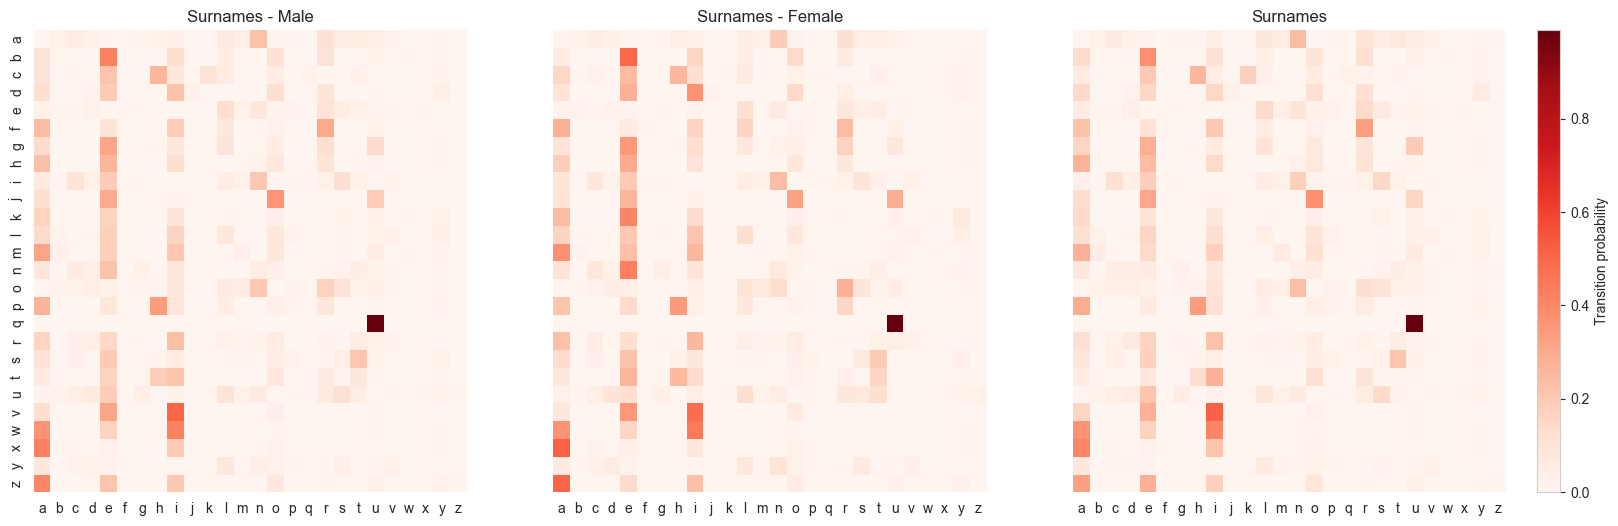

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)
hm1 = plot_transition_matrix(axes[0], names_transitions["df_probs"], "Native - Male")
hm2 = plot_transition_matrix(
    axes[1], names_transitions_females["df_probs"], "Native - Female"
)
hm3 = plot_transition_matrix(axes[2], names_transitions_males["df_probs"], "Native")
cbar = fig.colorbar(
    hm3.collections[0], ax=axes, orientation="vertical", fraction=0.03, pad=0.02
)
cbar.set_label("Transition probability")
plt.savefig("../assets/names_transition_probabilities.png")
plt.savefig("../assets/names_transition_probabilities.svg")

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)
hm4 = plot_transition_matrix(
    axes[0], surnames_transitions["df_probs"], "Surnames - Male"
)
hm5 = plot_transition_matrix(
    axes[1], surnames_transitions_females["df_probs"], "Surnames - Female"
)
hm6 = plot_transition_matrix(
    axes[2], surnames_transitions_males["df_probs"], "Surnames"
)
cbar = fig.colorbar(
    hm6.collections[0], ax=axes, orientation="vertical", fraction=0.03, pad=0.02
)
cbar.set_label("Transition probability")
plt.savefig("../assets/surnames_transition_probabilities.png")
plt.savefig("../assets/surnames_transition_probabilities.svg")
plt.show()

### Transition Probability Differences

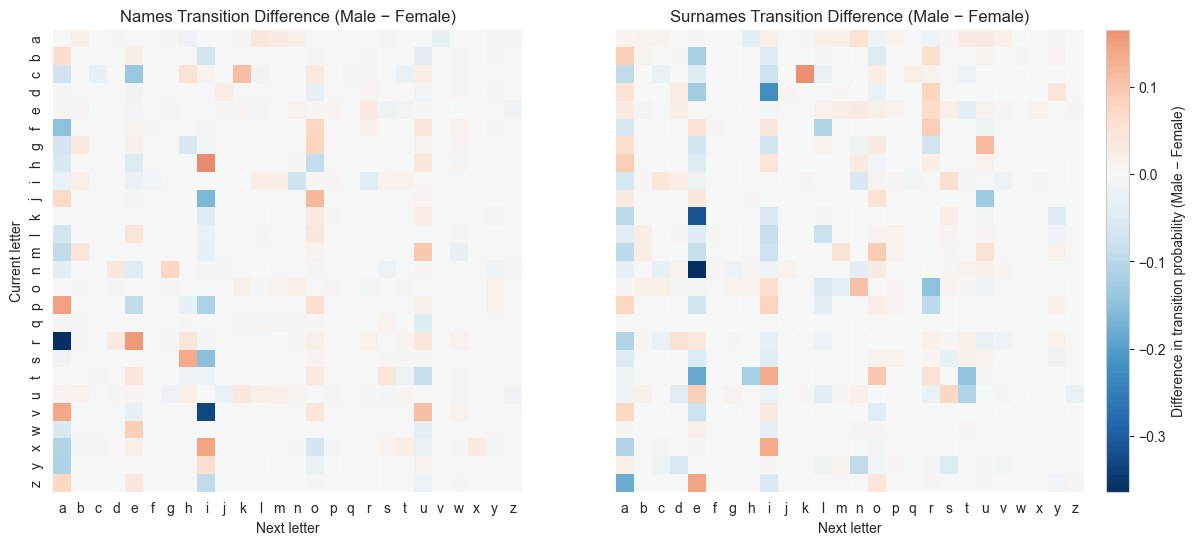

In [16]:
names_transitions_diff = (
    names_transitions_males["df_probs"] - names_transitions_females["df_probs"]
)
surnames_transitions_diff = (
    surnames_transitions_males["df_probs"] - surnames_transitions_females["df_probs"]
)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

hm1 = sns.heatmap(
    names_transitions_diff.loc[list(LETTERS), list(LETTERS)],
    cmap="RdBu_r",
    center=0,
    ax=axes[0],
    cbar=False,
)
axes[0].set_title("Names Transition Difference (Male − Female)")
axes[0].set_xlabel("Next letter")
axes[0].set_ylabel("Current letter")

hm2 = sns.heatmap(
    surnames_transitions_diff.loc[list(LETTERS), list(LETTERS)],
    cmap="RdBu_r",
    center=0,
    ax=axes[1],
    cbar=False,
)
axes[1].set_title("Surnames Transition Difference (Male − Female)")
axes[1].set_xlabel("Next letter")
axes[1].set_ylabel("")
cbar = fig.colorbar(
    hm2.collections[0], ax=axes, orientation="vertical", fraction=0.03, pad=0.02
)
cbar.set_label("Difference in transition probability (Male − Female)")

plt.savefig("../assets/transition_difference.png")
plt.show()

In [17]:
df_comparisons = build_transition_comparisons(
    {"m": names_transitions_males, "f": names_transitions_females},
    {"m": surnames_transitions_males, "f": surnames_transitions_females},
)
df_comparisons.to_csv("../assets/transition_comparisons.csv", index_label="category")
df_comparisons.head(3)

,l2,kl_mf,kl_fm,jsd,permutation_p_value
names,0.318904,0.043201,0.021538,0.032370,0.973
surnames,1.277002,0.293619,0.239895,0.266757,0.003


l2 (Euclidean Distance): This metric shows the overall magnitude of the difference between the two matrices. The value for surnames (1.277) is significantly higher than for names (0.3189), indicating that the male and female surname transition matrices are farther apart than those for first names.

kl_mf and kl_fm (Kullback-Leibler Divergence): These values measure the information lost when one gender's probability distribution is used to approximate the other. The values for surnames (0.2936 and 0.2399) are much larger than for names (0.0432 and 0.0215). This reinforces the L2 distance's finding: there's a greater difference in the letter patterns between male and female surnames.

jsd (Jensen-Shannon Divergence): This is a symmetric, smoothed version of KL divergence. The jsd for surnames (0.2668) is much higher than for names (0.0324), providing a single, clear measure of the greater divergence in surname patterns.

The permutation_p_value is the most crucial part of this analysis. It determines whether the observed differences are statistically significant or likely due to random chance.

names (p-value = 0.979): A p-value of 0.979 is very high, far greater than the common significance level of 0.05. This means there's a 97.9% chance of observing a difference this large or larger even if there were no real difference in letter transition patterns between male and female first names. Therefore, you cannot reject the null hypothesis that the patterns are the same. The observed small difference (JSD = 0.032) is not statistically significant.

surnames (p-value = 0.001): A p-value of 0.001 is very low, well below the significance level of 0.05. This means there's only a 0.1% chance of observing a difference this large or larger if there were no real difference. This provides strong statistical evidence to reject the null hypothesis. The significant difference (JSD = 0.266) is not random; it indicates a genuine, statistically significant difference in the letter transition patterns between male and female surnames.

Conclusion: The analysis confirms that male and female surnames have distinct, gender-specific letter transition patterns, while the patterns in first names are not statistically different.

### Letters frequency

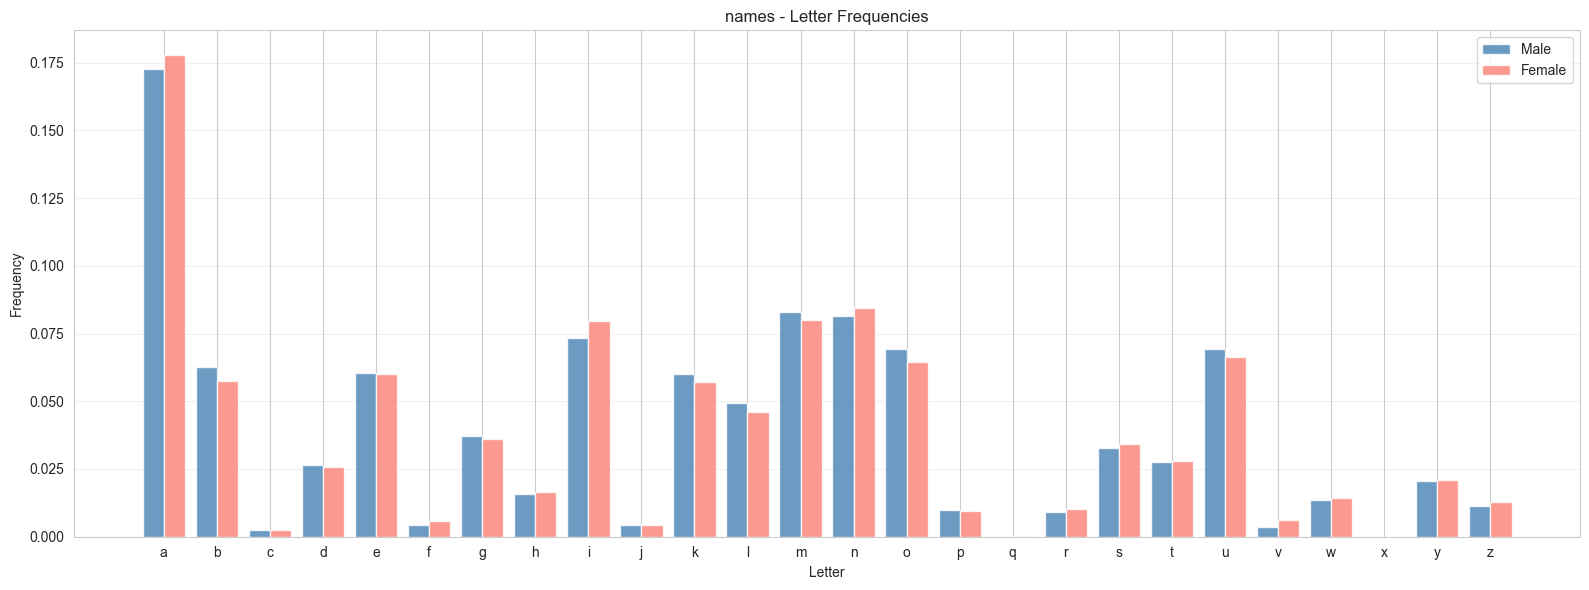

In [18]:
plot_letter_frequencies(df_names_m, df_names_f, title="names")

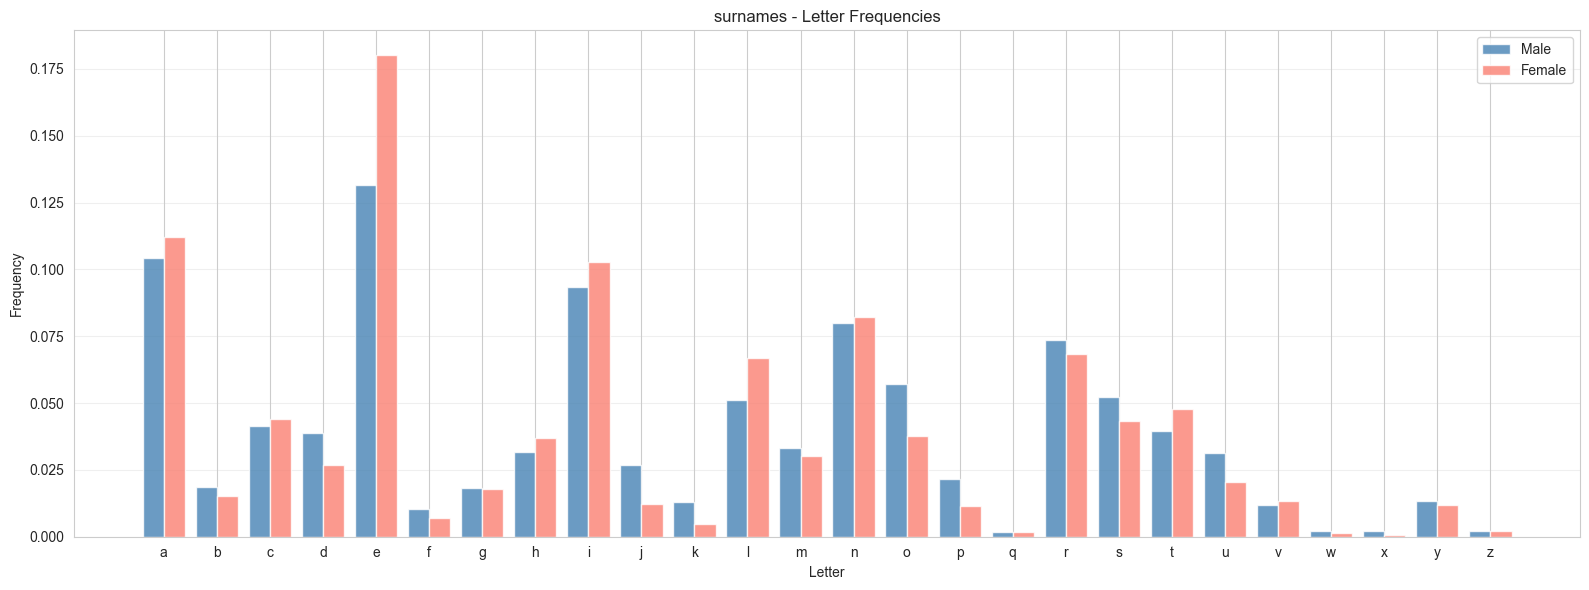

In [19]:
plot_letter_frequencies(df_surnames_m, df_surnames_f, title="surnames")

### N-grams analysis

#### Prefixes and Suffixes

In [20]:
import re


def _pick_ngram_col(df: pd.DataFrame) -> str:
    """Detect the n-gram column name like '2-gram', '3-gram', etc."""
    for c in df.columns:
        if isinstance(c, str) and c.endswith("-gram"):
            return c
    raise ValueError(f"Could not find an n-gram column in: {list(df.columns)}")


def build_ngram_summary_table(
    results: dict, top_k: int = 20, sep: str = ", "
) -> pd.DataFrame:
    """
    Convert dict of {subset_key: df} into rows of:
      sex | 2-grams | 3-grams | 4-grams | position

    Expected subset_key pattern: '{sex}_{position}_{n}', e.g. 'male_prefix_3', 'female_suffix_4', 'male_any_2'
    """
    rows = {}

    for key, df in results.items():
        # Parse key -> sex, position, n
        m = re.match(r"^(male|female)_(prefix|suffix|any)_(\d+)$", key)
        if not m:
            # Skip keys that don't match the expected pattern
            continue
        sex, position, n_str = m.groups()
        n = int(n_str)

        if df is None or df.empty:
            ng_list_str = ""
        else:
            ng_col = _pick_ngram_col(df)
            # take top_k, cast to string, join
            ng_list_str = sep.join(df[ng_col].astype(str).head(top_k).tolist())

        # group rows by (sex, position)
        rows.setdefault((sex, position), {}).update({f"{n}-grams": ng_list_str})

    # Build final table, ensuring all n columns are present
    records = []
    for (sex, position), cols in rows.items():
        record = {
            "sex": sex,
            "position": position,
            "2-grams": cols.get("2-grams", ""),
            "3-grams": cols.get("3-grams", ""),
            "4-grams": cols.get("4-grams", ""),
        }
        records.append(record)

    # Order: sex (male,female), then position (prefix, suffix, any)
    order_pos = {"prefix": 0, "suffix": 1, "any": 2}
    df_out = pd.DataFrame(records)
    if not df_out.empty:
        df_out["__pos_order"] = df_out["position"].map(order_pos).fillna(99)
        df_out = (
            df_out.sort_values(["sex", "__pos_order"])
            .drop(columns="__pos_order")
            .reset_index(drop=True)
        )
    return df_out

In [21]:
names_ngrams = {
    # male
    "male_prefix_2": build_ngrams_count(df_names_m, 2, "prefix"),
    "male_prefix_3": build_ngrams_count(df_names_m, 3, "prefix"),
    "male_prefix_4": build_ngrams_count(df_names_m, 4, "prefix"),
    "male_suffix_2": build_ngrams_count(df_names_m, 2, "suffix"),
    "male_suffix_3": build_ngrams_count(df_names_m, 3, "suffix"),
    "male_suffix_4": build_ngrams_count(df_names_m, 4, "suffix"),
    "male_any_2": build_ngrams_count(df_names_m, 2, "any"),
    "male_any_3": build_ngrams_count(df_names_m, 3, "any"),
    "male_any_4": build_ngrams_count(df_names_m, 4, "any"),
    # female
    "female_prefix_2": build_ngrams_count(df_names_f, 2, "prefix"),
    "female_prefix_3": build_ngrams_count(df_names_f, 3, "prefix"),
    "female_prefix_4": build_ngrams_count(df_names_f, 4, "prefix"),
    "female_suffix_2": build_ngrams_count(df_names_f, 2, "suffix"),
    "female_suffix_3": build_ngrams_count(df_names_f, 3, "suffix"),
    "female_suffix_4": build_ngrams_count(df_names_f, 4, "suffix"),
    "female_any_2": build_ngrams_count(df_names_f, 2, "any"),
    "female_any_3": build_ngrams_count(df_names_f, 3, "any"),
    "female_any_4": build_ngrams_count(df_names_f, 4, "any"),
}

In [22]:
names_ngrams_summary = build_ngram_summary_table(names_ngrams, top_k=10)

names_ngrams_summary.to_csv("../assets/names_ngrams_summary.csv", index=False)
names_ngrams_summary

,sex,position,2-grams,3-grams,4-grams
0,female,prefix,"ka, ma, mu, mb, ng, ba, ki, lu, ts, bo","tsh, kab, ngo, mas, kas, kal, muk, kav, mbu, man","tshi, kavi, ngoy, kaso, ilun, mbuy, kaba, ntum..."
1,female,suffix,"ba, ga, la, ka, ma, da, go, ya, bo, na","nga, mba, ngo, nda, ala, mbo, ngu, ndo, mbe, mbu","anga, amba, ongo, umba, inga, ombo, unga, enga..."
2,female,any,"ng, ka, mb, an, ba, ma, nd, ga, la, am","nga, mba, ang, ngo, amb, ong, nda, ala, mbo, eng","anga, amba, ongo, tshi, umba, inga, ombo, unga..."
3,male,prefix,"ka, mu, ma, ba, mb, ng, ki, lu, ts, bo","kab, tsh, kal, kas, muk, ngo, kam, mut, mul, mbu","tshi, ngoy, ilun, kaba, kaso, kamb, muke, kabe..."
4,male,suffix,"ba, ga, la, go, ka, da, bo, le, di, ma","nga, mba, ngo, nda, ala, mbo, ngu, mbe, ndo, ele","amba, ongo, anga, umba, unga, ombo, anda, enga..."
5,male,any,"ng, ka, mb, ba, an, ma, mu, nd, am, al","nga, mba, ngo, amb, ang, ong, ala, nda, shi, mbo","amba, ongo, anga, tshi, umba, unga, ombo, anda..."


In [23]:
surnames_ngrams = {
    # male
    "male_prefix_2": build_ngrams_count(df_surnames_m, 2, "prefix"),
    "male_prefix_3": build_ngrams_count(df_surnames_m, 3, "prefix"),
    "male_prefix_4": build_ngrams_count(df_surnames_m, 4, "prefix"),
    "male_suffix_2": build_ngrams_count(df_surnames_m, 2, "suffix"),
    "male_suffix_3": build_ngrams_count(df_surnames_m, 3, "suffix"),
    "male_suffix_4": build_ngrams_count(df_surnames_m, 4, "suffix"),
    "male_any_2": build_ngrams_count(df_surnames_m, 2, "any"),
    "male_any_3": build_ngrams_count(df_surnames_m, 3, "any"),
    "male_any_4": build_ngrams_count(df_surnames_m, 4, "any"),
    # female
    "female_prefix_2": build_ngrams_count(df_surnames_f, 2, "prefix"),
    "female_prefix_3": build_ngrams_count(df_surnames_f, 3, "prefix"),
    "female_prefix_4": build_ngrams_count(df_surnames_f, 4, "prefix"),
    "female_suffix_2": build_ngrams_count(df_surnames_f, 2, "suffix"),
    "female_suffix_3": build_ngrams_count(df_surnames_f, 3, "suffix"),
    "female_suffix_4": build_ngrams_count(df_surnames_f, 4, "suffix"),
    "female_any_2": build_ngrams_count(df_surnames_f, 2, "any"),
    "female_any_3": build_ngrams_count(df_surnames_f, 3, "any"),
    "female_any_4": build_ngrams_count(df_surnames_f, 4, "any"),
}

In [24]:
surnames_ngrams_summary = build_ngram_summary_table(surnames_ngrams, top_k=10)

surnames_ngrams_summary.to_csv("../assets/surnames_ngrams_summary.csv", index=False)
surnames_ngrams_summary

,sex,position,2-grams,3-grams,4-grams
0,female,prefix,"ma, ch, be, na, an, sa, es, jo, ju, me","mar, cha, est, chr, gra, dor, sar, rut, ben, mer","mari, chri, esth, grac, sara, dorc, ruth, rach..."
1,female,suffix,"ne, ie, te, le, ce, ia, se, el, ah, th","ine, tte, lle, rah, nce, ene, nne, her, lie, rie","ette, line, tine, elle, ther, arie, ille, rcas..."
2,female,any,"ne, in, el, an, ie, ri, ra, li, ar, er","ine, tte, ett, mar, ari, lle, lin, eli, the, ell","ette, line, ther, mari, tine, elle, rist, chri..."
3,male,prefix,"jo, je, pa, ch, ma, da, al, ju, be, fr","jea, jos, chr, pat, mar, jon, fra, dan, cha, ben","jean, chri, jose, jona, patr, fran, mich, emma..."
4,male,suffix,"in, el, an, ck, on, re, ce, er, se, is","ean, tin, ick, ier, ard, uel, ert, ain, iel, ise","jean, stin, rick, bert, seph, than, oise, avid..."
5,male,any,"an, er, el, ie, in, ri, is, on, en, re","ric, sti, jea, ean, tin, ris, ier, ist, ick, jos","jean, stin, rist, rick, chri, hris, usti, bert..."


## Name generation

In [25]:
# tokens must include '^' (start) and '$' (end)
tokens = ["^"] + list(LETTERS) + ["$"]
token_to_idx = {t: i for i, t in enumerate(tokens)}
idx_to_token = np.array(tokens)
V = len(tokens)


# Prepare a well-formed probability matrix (rows sum to 1, no NaNs/negatives)
def prepare_prob_matrix(df_probs, tokens):
    import pandas as pd
    import numpy as np

    if isinstance(df_probs, pd.DataFrame):
        P = df_probs.loc[tokens, tokens].to_numpy(dtype=float, copy=True)
    else:
        P = np.array(df_probs, dtype=float, copy=True)
        if P.shape[0] != len(tokens) or P.shape[1] != len(tokens):
            raise ValueError(
                f"Matrix shape {P.shape} does not match tokens length {len(tokens)}. "
                "Use the same tokens used to build the matrix (e.g., transitions['tokens'])."
            )
    # clean & renormalize
    P[~np.isfinite(P) | (P < 0)] = 0.0
    rs = P.sum(axis=1, keepdims=True)
    P = np.divide(P, np.where(rs == 0, 1.0, rs), out=np.zeros_like(P), where=True)
    return P


def generate_name(
    P,
    token_to_idx,
    idx_to_token,
    *,
    target_len=None,  # exact character length (letters only), if provided
    min_len=1,  # minimum character length
    max_len=12,  # hard cap on steps
    temperature=1.0,
):
    start = token_to_idx["^"]
    end = token_to_idx["$"]
    cur = start
    out = []

    for _ in range(max_len):
        row = P[cur]

        # Temperature scaling (τ<1 = sharper, τ>1 = flatter)
        if temperature != 1.0:
            row = np.power(row, 1.0 / temperature)
            s = row.sum()
            row = row / s if s > 0 else row

        row_mod = row.copy()

        # 1) Prevent early stop before min_len
        if len(out) < min_len:
            row_mod[end] = 0.0

        # 2) If target_len reached or exceeded, force end
        if target_len is not None and len(out) >= target_len:
            row_mod[:] = 0.0
            row_mod[end] = 1.0

        s = row_mod.sum()
        if s == 0.0:
            # Fallback: uniform over valid next tokens
            candidates = np.arange(V)
            # exclude '^'
            candidates = candidates[candidates != start]
            # exclude '$' if below min_len
            if len(out) < min_len:
                candidates = candidates[candidates != end]
            probs = np.ones(len(candidates)) / len(candidates)
            nxt_idx = np.random.choice(candidates, p=probs)
        else:
            row_mod = row_mod / s
            nxt_idx = np.random.choice(V, p=row_mod)

        if nxt_idx == end:
            break
        out.append(idx_to_token[nxt_idx])
        cur = nxt_idx

    return "".join(out).capitalize()

In [33]:
P = prepare_prob_matrix(names_transitions_males["df_probs"], tokens)
generated_var = [
    generate_name(P, token_to_idx, idx_to_token, min_len=5, max_len=12, temperature=0.5)
    for _ in range(10)
]

names = pd.DataFrame(generated_var, columns=["name"])
names

,name
0,Monga
1,Ngonganga
2,Kanda
3,Mbombonda
4,Mbanga
5,Mbanda
6,Manga
7,Bambi
8,Mbale
9,Mamba


In [32]:
P = prepare_prob_matrix(names_transitions_females["df_probs"], tokens)
generated_var = [
    generate_name(P, token_to_idx, idx_to_token, min_len=5, max_len=12, temperature=0.5)
    for _ in range(10)
]

names = pd.DataFrame(generated_var, columns=["name"])
names

,name
0,Mamba
1,Kanga
2,Mbokangango
3,Belango
4,Mbanga
5,Mungo
6,Langa
7,Kambo
8,Konga
9,Mbulu


In [35]:
P = prepare_prob_matrix(surnames_transitions_females["df_probs"], tokens)
generated_var = [
    generate_name(P, token_to_idx, idx_to_token, min_len=5, max_len=12, temperature=0.5)
    for _ in range(10)
]

names = pd.DataFrame(generated_var, columns=["name"])
names

,name
0,Jomane
1,Maielane
2,Miela
3,Canella
4,Thelie
5,Siele
6,Mielice
7,Juege
8,Anella
9,Sesane


In [34]:
P = prepare_prob_matrix(surnames_transitions_males["df_probs"], tokens)
generated_var = [
    generate_name(P, token_to_idx, idx_to_token, min_len=5, max_len=12, temperature=0.5)
    for _ in range(10)
]

names = pd.DataFrame(generated_var, columns=["name"])
names

,name
0,Jaman
1,Chistis
2,Mannane
3,Celerie
4,Jeusus
5,Drinie
6,Jerien
7,Seristinelel
8,Distugueran
9,Alanche
